In [29]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
model_weights = "/content/mnist_model_weights.pth"
weights = torch.load(model_weights)

In [4]:
weights.keys()

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

In [9]:
weights1 = weights['fc1.weight']
weights2 = weights['fc2.weight']
weights3 = weights['fc3.weight']

In [11]:
weights1.shape

torch.Size([784, 784])

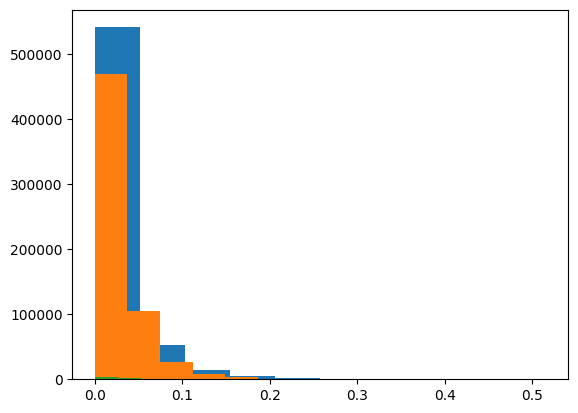

In [15]:
plt.hist(weights1.flatten().abs());
plt.hist(weights2.flatten().abs());
plt.hist(weights3.flatten().abs());


In [16]:
# convert weights into bipartite graph

import networkx as nx

G = nx.Graph()

G.add_nodes_from(range(weights1.shape[0]), bipartite=0)
G.add_nodes_from(range(weights1.shape[0], weights1.shape[0]+weights2.shape[0]), bipartite=1)

In [30]:
for i in tqdm(range(weights1.shape[0])):
  for j in range(weights1.shape[1]):
    G.add_edge(i, j+weights1.shape[0], weight=weights1[i,j])

100%|██████████| 784/784 [00:11<00:00, 68.19it/s]


In [42]:
weights1.shape

torch.Size([784, 784])

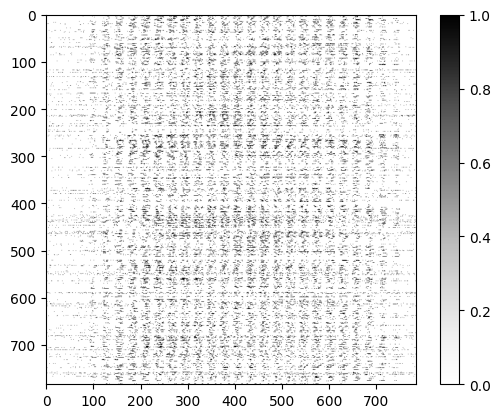

In [53]:
plt.imshow(weights1 > 0.05, cmap='Grays')
plt.colorbar()

# clustering

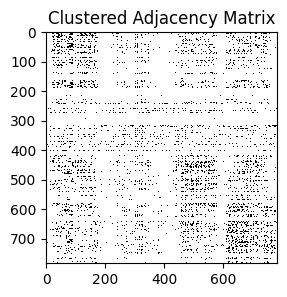

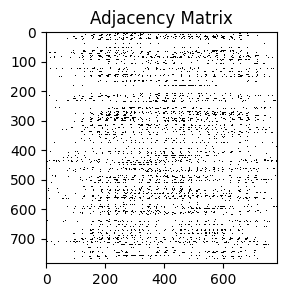

In [56]:
A = (weights1 > 0.05).numpy().astype(int)

import networkx as nx
import community  # from python-louvain package
import numpy as np
import matplotlib.pyplot as plt

# A: your adjacency matrix (numpy array)
G = nx.from_numpy_array(A)

# Example using connected components
components = list(nx.connected_components(G))
ordered_nodes = [node for comp in components for node in sorted(comp)]

partition = community.best_partition(G)
# Sort by community ID
ordered_nodes = sorted(partition.keys(), key=lambda x: partition[x])

A_ordered = A[np.ix_(ordered_nodes, ordered_nodes)]

plt.figure(figsize=(3, 3))
plt.imshow(A_ordered, cmap='Greys', interpolation='none')
plt.title('Clustered Adjacency Matrix')
# plt.axis('off')
plt.show()


plt.figure(figsize=(3, 3))
plt.imshow(A, cmap='Greys', interpolation='none')
plt.title('Adjacency Matrix')
# plt.axis('off')
plt.show()

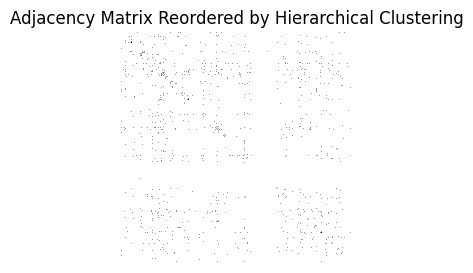

In [72]:
A = (weights2 > 0.1).numpy().astype(int)
A = (A + A.T) / 2  # ensure symmetry
from scipy.spatial.distance import pdist, squareform

# Invert adjacency to get distance; add small epsilon to avoid zero division
distance_matrix = 1 / (A + 1e-5)
np.fill_diagonal(distance_matrix, 0)  # ensure zero diagonal

from scipy.cluster.hierarchy import linkage, leaves_list

# Flatten the distance matrix to condensed form
condensed = squareform(distance_matrix)

# Compute linkage (can try 'average', 'ward', 'complete', etc.)
Z = linkage(condensed, method='ward')

# Get the order of nodes from the dendrogram
ordered_nodes = leaves_list(Z)

A_ordered = A[np.ix_(ordered_nodes, ordered_nodes)]

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.imshow(A_ordered, cmap='Greys', interpolation='none')
plt.title('Adjacency Matrix Reordered by Hierarchical Clustering')
plt.axis('off')
plt.show()

In [104]:
weights1.flatten().mean()+weights1.flatten().std(), weights1.flatten().median()

(tensor(0.0485), tensor(0.0065))

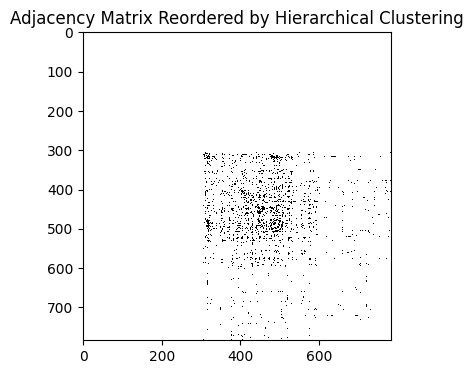

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

# Convert weights to binary adjacency matrix
A = (weights1.abs() > 0.05).numpy().astype(int)

# Ensure the adjacency matrix is symmetric
A = (A + A.T) // 2

# Compute distances between node connection profiles (rows of A)
distance_matrix = pdist(A + 1e-5, metric='correlation')  # cosine or 'correlation' is great for binary data

# Perform hierarchical clustering
Z = linkage(distance_matrix, method='ward')  # 'ward' works well for dense structures

# Get node ordering from dendrogram
ordered_nodes = leaves_list(Z)

# Reorder the adjacency matrix
A_ordered = A[np.ix_(ordered_nodes, ordered_nodes)]

# Visualize
plt.figure(figsize=(4, 4))
plt.imshow(A_ordered, cmap='Greys', interpolation='none')
plt.title('Adjacency Matrix Reordered by Hierarchical Clustering')
# plt.axis('off')
plt.show()

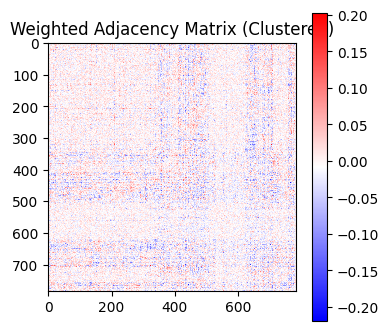

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

# Step 1: Convert to NumPy array
A = weights2.numpy()
A = (A + A.T) / 2  # ensure symmetry

# Optional: Normalize rows if necessary
# A = A / (A.sum(axis=1, keepdims=True) + 1e-8)

# Step 2: Compute distance between rows (connectivity patterns)
# Choose metric: 'cosine' or 'correlation' usually works well for weighted graphs
distance_matrix = pdist(A, metric='cosine')

# Step 3: Hierarchical clustering
Z = linkage(distance_matrix, method='ward')  # or 'average'
ordered_nodes = leaves_list(Z)

# Step 4: Reorder and plot
A_ordered = A[np.ix_(ordered_nodes, ordered_nodes)]

plt.figure(figsize=(4, 4))
plt.imshow(A_ordered, cmap='bwr', interpolation='none')  # use a color map for float values
plt.title("Weighted Adjacency Matrix (Clustered)")
# plt.xticks(range(len(ordered_nodes)), ordered_nodes, rotation=90)
# plt.yticks(range(len(ordered_nodes)), ordered_nodes)
plt.colorbar()
plt.show()

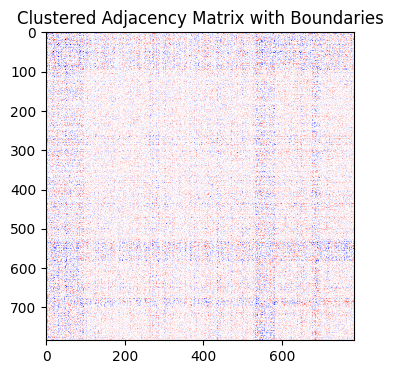

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

# Step 1: Prepare weighted adjacency matrix
A = weights2.numpy()
A = (A + A.T) / 2  # ensure symmetry

# Step 2: Compute distance between connection profiles
dist = pdist(A, metric='cosine')
dist_matrix = squareform(dist)

# Step 3: Perform Agglomerative Clustering
n_clusters = 6  # ← change this to desired number of clusters
model = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward'
)
labels = model.fit_predict(A)

# Step 4: Reorder nodes by cluster assignment
ordered_nodes = np.argsort(labels)
A_ordered = A[np.ix_(ordered_nodes, ordered_nodes)]

# Step 5: Visualize
plt.figure(figsize=(4, 4))
plt.imshow(A_ordered, cmap='bwr', interpolation='none')

# Add lines to show cluster boundaries
boundaries = np.cumsum(np.bincount(labels[ordered_nodes]))
# for b in boundaries[:-1]:
    # plt.axhline(b - 0.5, color='red', linewidth=0.5)
    # plt.axvline(b - 0.5, color='red', linewidth=0.5)

plt.title('Clustered Adjacency Matrix with Boundaries')
# plt.axis('off')
plt.show()

100%|██████████| 784/784 [00:21<00:00, 37.09it/s]


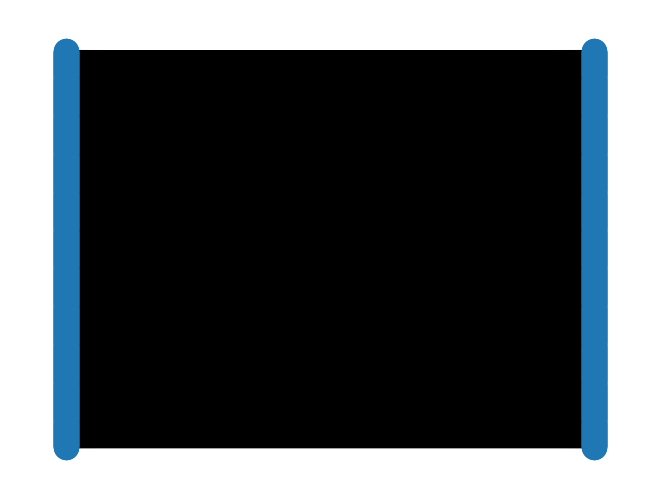

In [138]:
# Draw bipartite graph

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(range(weights1.shape[0]), bipartite=0)
G.add_nodes_from(range(weights1.shape[0], weights1.shape[0]+weights2.shape[0]), bipartite=1)

for i in tqdm(range(weights1.shape[0])):
  for j in range(weights1.shape[1]):
    G.add_edge(i, j+weights1.shape[0], weight=weights1[i,j].abs())

pos = nx.bipartite_layout(G, range(weights1.shape[0]))

# reduce edge width

nx.draw(G, pos, edge_color

In [160]:
left_nodes = np.arange(weights1.shape[0])
ordered_left = left_nodes[np.argsort(labels)]
right_nodes = np.arange(weights1.shape[0], weights1.shape[0] + weights1.shape[1])

G = nx.Graph()
G.add_nodes_from(ordered_left, bipartite=0)
G.add_nodes_from(right_nodes, bipartite=1)

edge_colors = []
edge_widths = []

for i in tqdm(ordered_left):
    for j in ordered_left:

        if labels[i] == labels[j]:
            edge_colors.append(labels[i])  # Color by cluster
            u, v = i, j + weights1.shape[0]
            w = weights1[i, j].abs().item()
            G.add_edge(u, v, weight=w)
            edge_widths.append(0.01)  # Thin edges

100%|██████████| 784/784 [00:28<00:00, 27.15it/s]


100%|██████████| 784/784 [00:05<00:00, 142.75it/s]


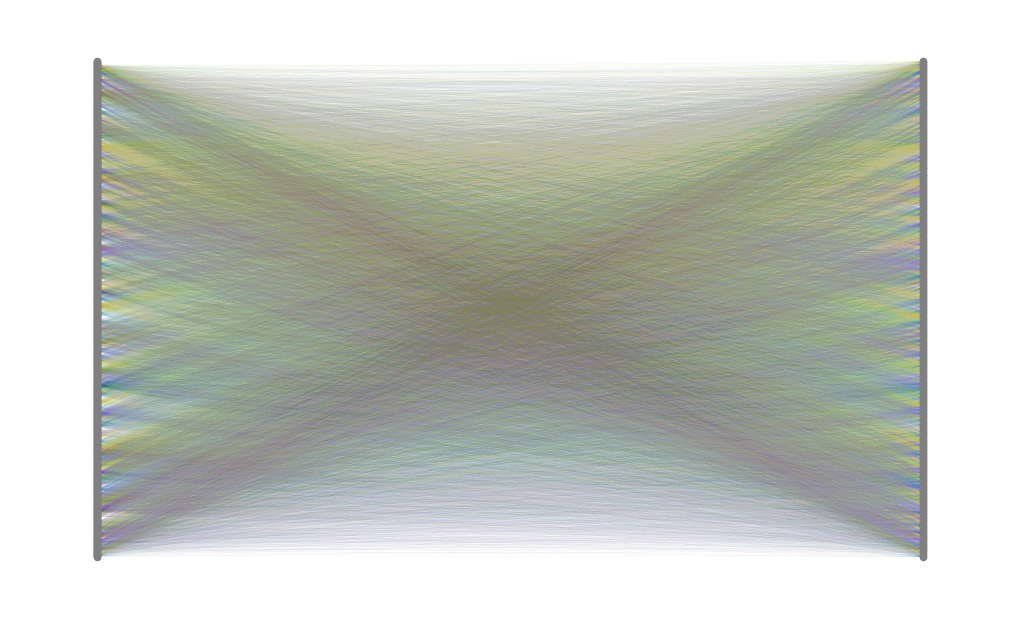

In [165]:
left_nodes = np.arange(weights1.shape[0])
ordered_left = left_nodes[np.argsort(labels)]
right_nodes = np.arange(weights1.shape[0], weights1.shape[0] + weights1.shape[1])

G = nx.Graph()
G.add_nodes_from(ordered_left, bipartite=0)
G.add_nodes_from(ordered_left, bipartite=1)

edge_colors = []
edge_widths = []

for i in tqdm(ordered_left):
    for j in ordered_left:

        if (labels[i] == labels[j]) and (labels[i] != 1):
            edge_colors.append(labels[i])  # Color by cluster
            u, v = i, j + weights1.shape[0]
            w = weights1[i, j].abs().item()
            G.add_edge(u, v, weight=w)
            edge_widths.append(0.01)  # Thin edges

pos = nx.bipartite_layout(G, ordered_left)

# Normalize cluster labels to colormap range
import matplotlib.cm as cm
import matplotlib.colors as mcolors

cmap = cm.get_cmap('tab10', n_clusters)
norm = mcolors.Normalize(vmin=1, vmax=n_clusters)
mapped_colors = [cmap(norm(c)) for c in edge_colors]

# Draw
plt.figure(figsize=(10, 6))
nx.draw(
    G, pos,
    with_labels=False,
    node_size=20,
    width=edge_widths,
    edge_color=mapped_colors,
    # alpha=0.3,               # transparency
    node_color='gray'
)
plt.axis('off')
plt.show()

In [162]:
import pandas as pd
pd.Series(labels).value_counts()

,count
1,435
0,96
3,94
5,87
2,51
4,21
